<a href="https://colab.research.google.com/github/SamuelFoo/ML/blob/master/CV2_Resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install object-detection-fastai
!pip install distro # For fastai.utils.collect_env.show_install

# For COCO eval
!pip install git+https://github.com/jinmingteo/cocoapi.git#subdirectory=PythonAPI
!pip install numpy==1.17

In [ ]:
# Regularisation - dropouts
# Change image sizes
# Try data normalisation - seems to work
# Make dataset more complete
# Does validation set have incomplete labels too?
# Should we apply nms/ thresh to filter output or not?
# Somehow when generating predictions, it skips through odd batches very quickly?
# Try Resnet34 or resnet50
# Exported bbox seems bigger than internal
# Train encoders?

import warnings
warnings.filterwarnings('ignore')

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

from fastai.utils.collect_env import show_install
show_install()

In [ ]:
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import numpy
numpy.__version__

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# !cp /content/gdrive/My\ Drive/ML/CV.zip .
# !unzip -q CV.zip
# !rm CV.zip
# !mv CV/val CV/valid
# !mv CV/val.json CV/valid.json
# !mv CV/val.p CV/valid.p

# !cp /content/gdrive/My\ Drive/ML/CV_final_images.zip .
# !unzip -q CV_final_images.zip
# !mv -n CV_final_images CV/test
# !cp /content/gdrive/My\ Drive/ML/CV_final_evaluation.json CV/test.json

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
# Because dataloader requires annotations, format given json to include dummy annotations
with open("CV/test.json") as f:
  test_dict = json.load(f)

annot_list = []
for i in range(len(test_dict["images"])):
  annot_dict = {}
  annot_dict["image_id"] = test_dict["images"][i]["id"]
  annot_dict["bbox"] = [1,2,3,4]
  annot_dict["category_id"] = 1
  annot_list.append(annot_dict)

test_dict["annotations"] = annot_list

with open("CV/test_1.json", "w") as f:
  json.dump(test_dict, f)

In [ ]:
root_dir = Path("CV")

def get_data(size, batch, val_annot):
  train_images, train_lbl_bbox = get_annotations(root_dir/'train.json')
  val_images, val_lbl_bbox = get_annotations(root_dir/val_annot)
  print(train_images[0], train_lbl_bbox[0])
  print(len(train_images), len(val_images)) # Should be (8225, 1474)

  images, lbl_bbox = train_images+val_images,train_lbl_bbox+val_lbl_bbox
  img2bbox = dict(zip(images, lbl_bbox))
  get_y_func = lambda o:img2bbox[o.name]

  data = (ObjectItemList.from_folder(root_dir)
          #Where are the images? -> in coco
          .split_by_files(val_images)
          #How to split in train/valid? -> by file names
          .label_from_func(get_y_func)
          #How to find the labels? -> use get_y_func
          .transform(get_transforms(), tfm_y=True, size=size)
          #Data augmentation? -> Standard transforms with tfm_y=True
          .databunch(bs=batch, collate_fn=bb_pad_collate))
          #Finally we convert to a DataBunch and we use bb_pad_collate
  data = data.normalize()
  return data

In [ ]:
data = get_data(256, 64, "valid.json")

In [ ]:
data.classes
# data.show_batch(rows=5, ds_type=DatasetType.Valid, figsize=(15,15))

In [ ]:
ratios = [0.5, 1, 2]
scales = [0.35, 0.5, 0.6, 1, 1.25, 1.6]
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=ratios, scales=scales)

# all_boxes, all_labels = show_anchors_on_images(data, anchors, figsize=(25,25))

In [ ]:
n_classes = data.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet50, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=18, sizes=[32,16,8,4], chs=32, final_bias=-4., n_conv=2)

In [ ]:
size = 256
voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics],
                metrics=[voc])
learn.split([model.encoder[6], model.c5top5]);

In [ ]:
def loadModelFromDrive(model):
  !mkdir CV/models
  !cp gdrive/My\ Drive/Colab\ Notebooks/{model}.pth CV/models/{model}.pth
  learn.load(model);

def saveModelToDrive(model):
  learn.save(model)
  !cp CV/models/{model}.pth gdrive/My\ Drive/Colab\ Notebooks/{model}.pth

# Train

In [ ]:
# learn.freeze()
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

In [ ]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, 1e-4)

In [ ]:
saveModelToDrive("third-norm-resnet50")

In [ ]:
loadModelFromDrive("third-norm-resnet50")

In [ ]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.recorder.plot(suggestion=True)
plt.ylim(0.4, 0.5)

In [ ]:
learn.fit_one_cycle(5, 5.75E-06)

In [ ]:
saveModelToDrive("fourth-norm-resnet-50-v2")

In [ ]:
learn.save("unsure-norm-resnet-50")

In [ ]:
learn.export()

In [ ]:
show_results_side_by_side(learn, anchors, detect_thresh=0.25, nms_thresh=0.1, image_count=10)

In [ ]:
'''
Pascal-VOC Metric: (defaulkt: detect_thresh=0.25, nms=0.1)

first: 0.249684
first-norm-resnet18: 0.269669
second-norm-resnet18: 0.299878; result: 0.269
third-norm-resnet18: 0.314543

unsure-norm-resnet-50: 0.315430 result: 0.286

second-norm-resnet-50: ? results:
0.361 (detect_thresh=0.05, nms=0.5), 0.379 (detect_thresh=0.05, nms=0.8)

third-norm-resnet-50: 0.328370 results:
0.296 (detect_thresh=0.05, nms=0.1), 0.369 (detect_thresh=0.05, nms=0.6)

fourth-norm-resnet-50: 0.317036
'''

# Inference

In [ ]:
learn.data = get_data(256, 64, "valid.json")

In [ ]:
# !mv -n CV/valid valid_orig
# !mv -n test CV/valid
# learn.data = get_data(256, 64, "interim.json")

In [ ]:
valid_df = learn.data.valid_ds.to_df()

In [ ]:
dims = []
dl_names = np.array(valid_df.x)

for path in dl_names:
  img = open_image(root_dir/path)
  dims.append(img.shape)

In [ ]:
dl_names = np.array(valid_df.x)
dl_img_ids = []
for name in dl_names:
  dl_img_ids.append(int(str(name).split(".")[0].split("/")[1]))

In [ ]:
dl_iter = iter(learn.data.valid_dl)

# Cat_id doesn't tally with prediction index
# categories = ['dresses', 'outerwear', 'skirts', 'tops', 'trousers']
# categories = [{"id": 1, "name": "tops"}, {"id": 2, "name": "trousers"}, {"id": 3, "name": "outerwear"}, {"id": 4, "name": "dresses"}, {"id": 5, "name": "skirts"}]
catMap = {0:4, 1:3, 2:5, 3:1, 4:2}
numBatch = len(learn.data.valid_dl)

In [ ]:
detect_thresh=0.05
nms_thresh=0.6

idx = 0
detections = []
images = []
batch_i = 0

with torch.no_grad():

  while True:
    try:
      img_batch, target_batch = next(dl_iter)
    except StopIteration:
      break

    print("Batch", batch_i+1, "of", numBatch, "image", idx)
    batch_i += 1
    
    prediction_batch = learn.model(img_batch)
    class_pred_batch, bbox_pred_batch = prediction_batch[:2]

    for clas_pred, bbox_pred, img in list(zip(class_pred_batch, bbox_pred_batch, img_batch)):

      if hasattr(learn.data, 'stats'):
        img = Image(learn.data.denorm(img))
      else:
        img = Image(img)
      
      bbox_pred, scores, preds = process_output(clas_pred, bbox_pred, anchors, detect_thresh)
      if bbox_pred is not None:
        to_keep = nms(bbox_pred, scores, nms_thresh)
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()

      _, W, H = dims[idx]
      t_sz = torch.Tensor([W, H])[None].cpu()
      img_id = dl_img_ids[idx]
      filename = str(dl_names[idx]).split("/")[1]

      if bbox_pred is not None:
        bbox_pred = to_np(rescale_boxes(bbox_pred.cpu(), t_sz))
        # change from center to top left
        bbox_pred[:, :2] = bbox_pred[:, :2] - bbox_pred[:, 2:] / 2

      idx += 1

      images.append({"file_name": filename, "id": img_id})

      if bbox_pred is None:
        print("No detections on image", idx)
        continue

      for j in range(len(bbox_pred)):
        x, y, w, h = bbox_pred[j]
        x, y, w, h = float(x), float(y), float(w), float(h)

        left = round(x,1)
        top = round(y,1)
        width = round(w,1)
        height = round(h,1)
        
        cat_id = catMap[int(preds[j])]
        detections.append( {'image_id':img_id, 'category_id':cat_id, 'bbox':[top, left, height, width], 'score':float(scores[j])} )
      
with open('CV/detections.json', 'w') as f:
  json.dump(detections, f)

Batch 1 of 24 image 0
Batch 2 of 24 image 64
Batch 3 of 24 image 128
Batch 4 of 24 image 192
Batch 5 of 24 image 256
Batch 6 of 24 image 320
Batch 7 of 24 image 384
Batch 8 of 24 image 448
Batch 9 of 24 image 512
Batch 10 of 24 image 576
Batch 11 of 24 image 640
Batch 12 of 24 image 704
Batch 13 of 24 image 768
Batch 14 of 24 image 832
Batch 15 of 24 image 896
Batch 16 of 24 image 960
Batch 17 of 24 image 1024
Batch 18 of 24 image 1088
Batch 19 of 24 image 1152
Batch 20 of 24 image 1216
Batch 21 of 24 image 1280
Batch 22 of 24 image 1344
Batch 23 of 24 image 1408
Batch 24 of 24 image 1472


In [ ]:
# Export to visualise (to check that predictions are exported correctly)
categories = [{"id": 1, "name": "tops"}, {"id": 2, "name": "trousers"}, {"id": 3, "name": "outerwear"}, {"id": 4, "name": "dresses"}, {"id": 5, "name": "skirts"}]
check_json = {"annotations": detections, "images": images, "categories": categories}

with open('CV/detections_check.json', 'w') as f:
  json.dump(check_json, f)

In [ ]:
# Get evaluation score against validation set
coco_gt = COCO('CV/valid.json')
coco_dt = coco_gt.loadRes('CV/detections.json')
cocoEval = COCOeval(cocoGt=coco_gt, cocoDt=coco_dt, iouType='bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=2.19s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.45s).
Accumulating evaluation results...
DONE (t=3.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.180
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [ ]:
data_test = get_data(256, 64, "detections_check.json")

10.jpg [[[620, 704, 2265, 2105]], ['dresses']]
8225 1474


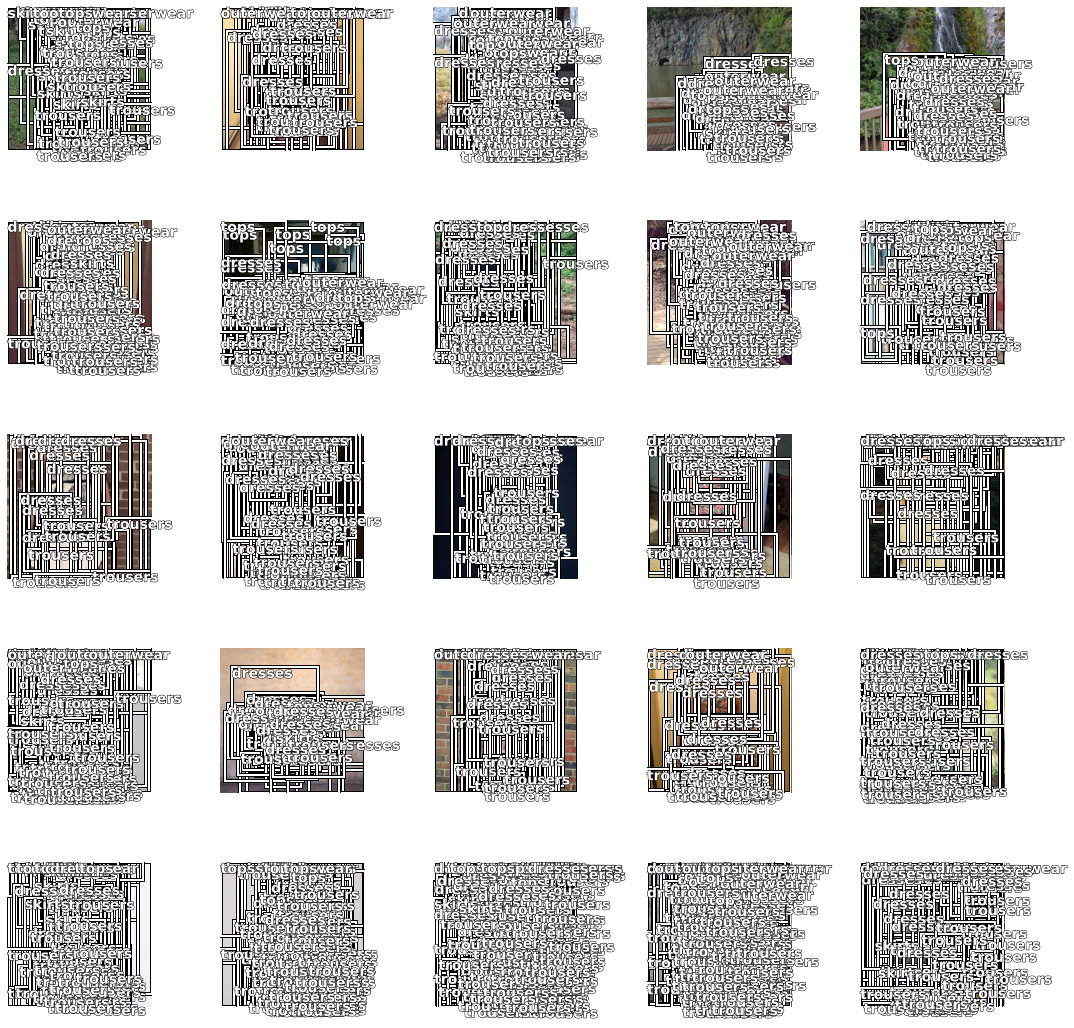

In [ ]:
data_test.show_batch(rows=5, ds_type=DatasetType.Valid, figsize=(15,15))

Interim 2 detect_thresh: 0.05, nms_thresh: 0.5

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.75s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.36s).
Accumulating evaluation results...
DONE (t=1.96s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.261
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.299

In [ ]:
with open("detections.json") as f:
  detections = json.load(f)

for detection in detections:
  x1, y1, x2, y2 = detection["bbox"]
  detection["bbox"] = [x1, y1, x2-x1, y2-y1]

with open("detections_wh.json", "w") as f:
  json.dump(detections, f)

In [ ]:
with open("detections_wh.json") as f:
  detections = json.load(f)

images = []
for detection in detections:
  img_id = detection["image_id"]
  filename = str(img_id)+".jpg"
  images.append({"file_name": filename, "id": img_id})

In [ ]:
# Export to visualise (to check that predictions are exported correctly)
categories = [{"id": 1, "name": "tops"}, {"id": 2, "name": "trousers"}, {"id": 3, "name": "outerwear"}, {"id": 4, "name": "dresses"}, {"id": 5, "name": "skirts"}]
check_json = {"annotations": detections, "images": images, "categories": categories}

with open('CV/detections_check.json', 'w') as f:
  json.dump(check_json, f)

In [ ]:
data_test = get_data(256, 64, "detections_check.json")

10.jpg [[[620, 704, 2265, 2105]], ['dresses']]
8225 1474


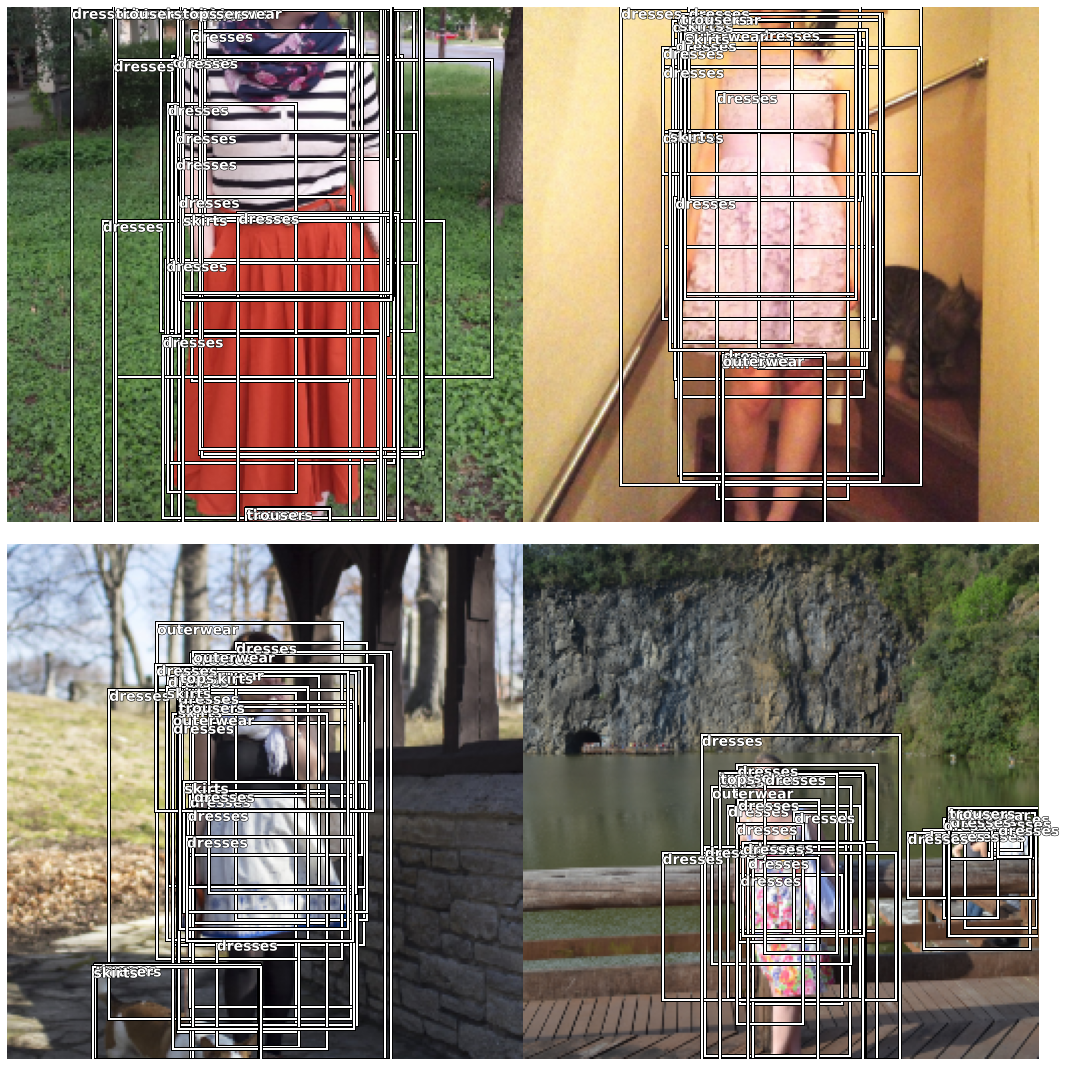

In [ ]:
data_test.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(15,15))

In [ ]:
coco_gt = COCO('CV/valid.json')
coco_dt = coco_gt.loadRes('detections_wh.json')
cocoEval = COCOeval(cocoGt=coco_gt, cocoDt=coco_dt, iouType='bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.14s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.90s).
Accumulating evaluation results...
DONE (t=0.77s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets